In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from natsort import natsorted
import GEOparse as geo
from glob import glob
import os
from os.path import basename, splitext

from sklearn.decomposition import PCA

# PARSE GSE

In [2]:
gse_id = 'GSE62772'
gse_path = './data/' + gse_id

In [3]:
try:
    os.mkdir(gse_path)
except:
    pass

In [4]:
try:
    gse = geo.get_GEO(geo=gse_id, destdir=gse_path)
except:
    gse = geo.get_GEO(geo=gse_id, destdir=gse_path)

26-Nov-2021 15:55:14 DEBUG utils - Directory ./data/GSE62772 already exists. Skipping.
26-Nov-2021 15:55:14 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE62nnn/GSE62772/soft/GSE62772_family.soft.gz to ./data/GSE62772/GSE62772_family.soft.gz
100%|██████████| 6.21k/6.21k [00:01<00:00, 6.25kB/s]
26-Nov-2021 15:55:16 DEBUG downloader - Size validation passed
26-Nov-2021 15:55:16 DEBUG downloader - Moving /tmp/tmpb4bahw9l to /gss/home/d.kriukov/Reprog/Reprogramming_meta/data/GSE62772/GSE62772_family.soft.gz
26-Nov-2021 15:55:16 DEBUG utils - Directory ./data/GSE62772 already exists. Skipping.
26-Nov-2021 15:55:16 INFO GEOparse - File already exist: using local version.
26-Nov-2021 15:55:16 INFO GEOparse - Parsing ./data/GSE62772/GSE62772_family.soft.gz: 
26-Nov-2021 15:55:16 DEBUG GEOparse - DATABASE: GeoMiame
26-Nov-2021 15:55:16 DEBUG GEOparse - SERIES: GSE62772
26-Nov-2021 15:55:16 DEBUG GEOparse - PLATFORM: GPL11154
26-Nov-2021 15:55:16 DEBUG GEOparse - PLATFORM: 

In [5]:
links = gse.metadata['supplementary_file']
links

['ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE62nnn/GSE62772/suppl/GSE62772_all_genes_LSD1i.fpkm_tracking.csv.gz',
 'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE62nnn/GSE62772/suppl/GSE62772_all_genes_fibroblasts.fpkm_tracking.csv.gz',
 'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE62nnn/GSE62772/suppl/GSE62772_all_genes_reprogramming.fpkm_tracking.csv.gz']

In [6]:
#save phenotype annotation data
gse.phenotype_data.to_csv(gse_path + '/{0}_metadata.csv'.format(gse_id))

In [7]:
#download files from supplementary table of GSE
for file_link in links:
    print(file_link)
    os.system("wget {0} --directory-prefix={1}".format(file_link, gse_path))

ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE62nnn/GSE62772/suppl/GSE62772_all_genes_LSD1i.fpkm_tracking.csv.gz
ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE62nnn/GSE62772/suppl/GSE62772_all_genes_fibroblasts.fpkm_tracking.csv.gz
ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE62nnn/GSE62772/suppl/GSE62772_all_genes_reprogramming.fpkm_tracking.csv.gz


In [8]:
#unpack the if needed
for f in glob(gse_path + '/*'):
    os.system("tar -xvf {0} -C {1}".format(f, gse_path))

In [16]:
!gzip -d data/GSE62772/GSE62772_all_genes_fibroblasts.fpkm_tracking.csv.gz


gzip: data/GSE62772/GSE62772_all_genes_fibroblasts.fpkm_tracking.csv.gz: invalid compressed data--format violated


In [10]:
#decompress the if needed gz files
for f in glob(gse_path + '/*.gz'):
    os.system("gzip -d {0}".format(f))


# GSE 102348

In [145]:
meta = pd.read_csv('data/GSE102348/GSE102348_metadata.csv', index_col=0)
lis = natsorted(glob('./data/GSE102348/*.txt'))

types = [l.split('_')[1] for l in lis]
types.remove('Myc')

df_list = []

for t in types:
    i = np.argwhere([t in l for l in lis])[0][0]
    p = lis[i]
    df = pd.read_csv(p, sep='\t').drop('Symbol', 1).set_index('Gene ID')
    di = meta[meta.title.str.contains(t)]['characteristics_ch1.1.stage of reprogramming'].to_dict()
    di = dict((v,k) for k,v in di.items())
    f = lambda x: di[x] if di.get(x) else x
    df.columns = df.columns.map(f)

    df_list.append(df)

In [151]:
from functools import reduce
df = reduce(lambda df1, df2: pd.merge(df1, df2, how='inner', on='Gene ID'), df_list)

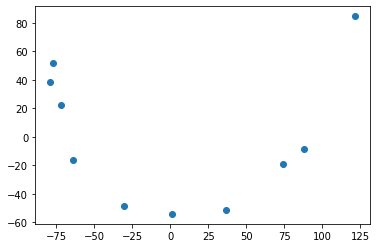

In [169]:
X = PCA(2).fit_transform(np.log2(df_list[0].T + 1))
plt.scatter(X[:,0], X[:,1])

In [158]:
#df.to_csv('data/GSE102348/GSE102348_raw_data.csv')

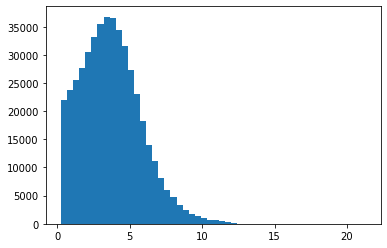

In [226]:
plt.hist(np.log2(k[np.where((k > 1.2))]), bins=50);

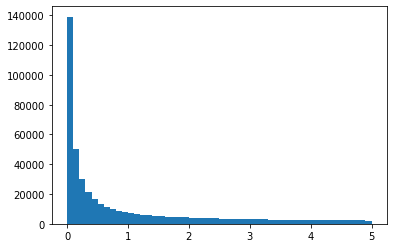

In [200]:
k = np.array(df).ravel()
plt.hist(k[np.where((k > 1.2)&(k < 5))], bins=50);

(12795, 34)


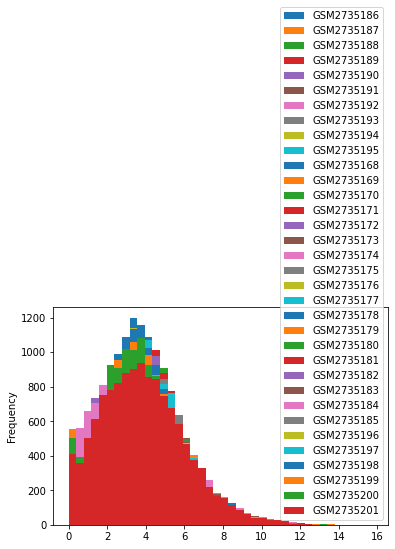

In [247]:
fpkm_thr = 1. #recommended by https://www.biostars.org/p/358433/
percentage_thr = 0.5 #chosen from looking at plot below

df_filtered = df[(df > fpkm_thr).sum(1) > df.shape[1] * percentage_thr]
print(df_filtered.shape)
np.log2(df_filtered + 1.).plot(kind='hist', bins=40);

In [249]:
df_filtered_log = np.log2(df_filtered + 1.)

In [253]:
#df_filtered_log.to_csv('data/GSE102348/GSE102348_preprocessed.csv')

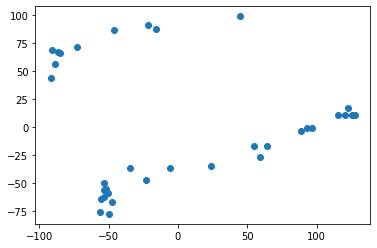

In [252]:
X = PCA(2).fit_transform(df_filtered_log.T)
plt.scatter(X[:,0], X[:,1])

# GSE127927

'GSM3656666'

In [80]:
lis = natsorted(glob('./data/GSE127927/GSE127927_RAW/*.txt'))

p = lis[0]
name = basename(p).split('_')[0]
df = pd.read_csv(p, sep='\t').set_index('gene_id')['expected_count'].rename(name)

for p in lis[1:]:
    name = basename(p).split('_')[0]
    tmp = pd.read_csv(p, sep='\t').set_index('gene_id')['expected_count'].rename(name)
    df = pd.concat([df, tmp], axis=1)


In [82]:
#df.to_csv('data/GSE127927/GSE127927_raw_table.csv', sep='\t')

In [83]:
#S = df.expected_count.sum()
#RPK = df.expected_count / (df.effective_length + 1) / 1000
#RPK / (RPK.sum() / 1_000_000)

In [48]:
df

,gene_id,transcript_id(s),length,effective_length,expected_count,TPM,FPKM
0,ENSMUSG00000000001,ENSMUST00000000001,3262.00,3188.51,922.00,83.90,48.31
1,ENSMUSG00000000003,"ENSMUST00000000003,ENSMUST00000114041",799.50,726.01,0.00,0.00,0.00
2,ENSMUSG00000000028,"ENSMUST00000000028,ENSMUST00000096990,ENSMUST0...",1977.82,1904.33,169.00,25.75,14.83
3,ENSMUSG00000000031,"ENSMUST00000132294,ENSMUST00000136359,ENSMUST0...",1943.58,1870.09,55601.64,8626.86,4967.76
4,ENSMUSG00000000037,"ENSMUST00000019101,ENSMUST00000074802,ENSMUST0...",3496.00,3422.51,13.00,1.10,0.63
...,...,...,...,...,...,...,...
54747,ENSMUSG00000117651,ENSMUST00000233998,797.00,723.51,0.00,0.00,0.00
54748,ENSMUSG00000117652,ENSMUST00000176586,479.00,405.51,0.00,0.00,0.00
54749,ENSMUSG00000117653,ENSMUST00000234275,1312.00,1238.51,0.00,0.00,0.00
54750,ENSMUSG00000117654,ENSMUST00000234587,1195.00,1121.51,0.00,0.00,0.00


# GSE103979

In [42]:
df = pd.read_csv(gse_path + '/GSE103979_genes_ntc_expression_v90_GEO.tsv', sep='\t')
#df.columns = [c.replace('WT', '') for c in df.columns]

In [64]:
pheno = pd.read_csv(gse_path + '/GSE103979_metadata.csv', index_col=0)

pheno[pheno.title.str.contains('GFP')].title

GSM3381672    GFPday0rep1
GSM3381673    GFPday0rep2
GSM3381674    GFPday1rep1
GSM3381675    GFPday1rep2
GSM3381676    GFPday3rep1
GSM3381677    GFPday3rep2
GSM3381678    GFPday5rep1
GSM3381679    GFPday5rep2
GSM3381680    GFPday8rep1
GSM3381681    GFPday8rep2
Name: title, dtype: object

In [44]:
colmap = dict(zip([c.replace('WT', '') for c in pheno.title.values], pheno.title.index))

In [45]:
df = df.rename(columns=colmap)
df = df.drop(['enst', 'tss', 'strand'], 1)

In [49]:
df.columns

Index(['ensg', 'name', 'GSM2787321', 'GSM2787269', 'GSM2787295', 'GSM2787270',
       'GSM2787296', 'GSM2787271', 'GSM2787297', 'GSM2787272', 'GSM2787298',
       'GSM2787273', 'GSM2787299', 'GSM2787274', 'GSM2787300', 'GSM2787275',
       'GSM2787301', 'GSM2787276', 'GSM2787302', 'GSM2787277', 'GSM2787303',
       'GSM2787278', 'GSM2787304', 'GSM2787284', 'GSM2787310', 'GSM2787285',
       'GSM2787311', 'GSM2787286', 'GSM2787312', 'GSM2787287', 'GSM2787313',
       'GSM2787288', 'GSM2787314', 'GSM3381672', 'GSM3381673', 'GSM3381674',
       'GSM3381675', 'GSM3381676', 'GSM3381677', 'GSM3381678', 'GSM3381679',
       'GSM3381680', 'GSM3381681'],
      dtype='object')

In [50]:
#df.to_csv(gse_path + '/raw_data.csv')

In [57]:
# Ensembl stable identifiers
# • ENSG########### Ensembl Gene ID
# • ENST########### Ensembl Transcript ID
# • ENSP########### Ensembl Peptide ID
# • ENSE########### Ensembl Exon ID
# • For non-human species a suffix is added:
# MUS (Mus musculus) for mouse: ENSMUSG
# DAR (Danio rerio) for zebrafish: ENSDARG


# GSE161057

In [21]:
p = glob(gse_path + '/*.csv')[0]
raw_counts = pd.read_csv(p, index_col=0)

In [23]:
p

'./Data/GSE161057/GSE161057_Raw_gene_counts_matrix.csv'

In [24]:
raw_counts

,Associated.Gene.Name,Chromosome.Name,DR_D0,DR_D1,DR_D3,DR_D5,DR_D7,FoxO6_D0,FoxO6_D1,FoxO6_D3,FoxO6_D5,FoxO6_D7
ENSMUSG00000000001,Gnai3,3,141.0,194.0,159.0,155.0,252.0,302.0,264.0,202.0,235.0,166.0
ENSMUSG00000000003,Pbsn,X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000000028,Cdc45,16,47.0,38.0,22.0,47.0,50.0,38.0,28.0,46.0,63.0,26.0
ENSMUSG00000000031,H19,7,552.0,119.0,120.0,127.0,120.0,1322.0,271.0,279.0,344.0,336.0
ENSMUSG00000000037,Scml2,X,7.0,13.0,7.0,9.0,6.0,4.0,9.0,7.0,10.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000110715,RP23-83G5.2,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000110716,RP24-94F12.4,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000110717,RP23-44D2.1,8,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
ENSMUSG00000110718,RP23-60O19.1,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


# GSE115451

In [ ]:
ex = glob(gse_path + '/D12_Sox2_WT_vs_D12_Sox2_delta(120-180)_output/*')[2]
glob(gse_path + '/D12_Sox2_WT_vs_D12_Sox2_delta(120-180)_output/*')

In [ ]:
df = pd.read_csv(ex, sep='\t')

In [ ]:
df.columns

# GSE102348

* What duplicates in genes mean?
    * I have summed up it

In [92]:
gse = glob("./Data/GSE102348/*")
gse

['./Data/GSE102348/GSE102348_Myc_pert.fpkm.txt',
 './Data/GSE102348/GSE102348_WT-2_fpkm.txt',
 './Data/GSE102348/GSE102348_WT-1_fpkm.txt',
 './Data/GSE102348/GSE102348_Mbd3f_-_fpkm.txt',
 './Data/GSE102348/GSE102348_Gatad2a-_fpkm.txt']

In [98]:
#preprocessing and merging
symbols = {}
mdf = pd.DataFrame()

for path in tqdm(gse):

    df = pd.read_csv(path, sep='\t', index_col=0)
    symbols.update(df.Symbol.to_dict())
    df = df.groupby(level=0).sum()
    df.columns = [col + '__' + os.path.basename(path) for col in df.columns]

    if mdf.shape == (0, 0):
        mdf = df
    else:
        mdf = pd.merge(mdf, df, left_index=True, right_index=True)

In [104]:
mdf

,OSK_OE_D4__GSE102348_Myc_pert.fpkm.txt,siMyc_D3__GSE102348_Myc_pert.fpkm.txt,OSK_Myc_OE_D4__GSE102348_Myc_pert.fpkm.txt,Myc_OE_D4__GSE102348_Myc_pert.fpkm.txt,siMyc_D7__GSE102348_Myc_pert.fpkm.txt,Myc_inh_D3__GSE102348_Myc_pert.fpkm.txt,siControl_MEF_1__GSE102348_Myc_pert.fpkm.txt,siControl_MEF_2__GSE102348_Myc_pert.fpkm.txt,siControl_D7__GSE102348_Myc_pert.fpkm.txt,MEF__GSE102348_WT-2_fpkm.txt,...,MEF__GSE102348_Gatad2a-_fpkm.txt,Day1__GSE102348_Gatad2a-_fpkm.txt,Day2__GSE102348_Gatad2a-_fpkm.txt,Day3__GSE102348_Gatad2a-_fpkm.txt,Day4__GSE102348_Gatad2a-_fpkm.txt,Day5__GSE102348_Gatad2a-_fpkm.txt,Day6__GSE102348_Gatad2a-_fpkm.txt,Day7__GSE102348_Gatad2a-_fpkm.txt,Day8__GSE102348_Gatad2a-_fpkm.txt,IPS__GSE102348_Gatad2a-_fpkm.txt
ENSMUSG00000000001,70.20880,49.087200,85.86440,44.648300,53.779100,31.38270,59.543600,56.09610,51.050600,40.96310,...,61.51270,125.69800,80.78640,73.25330,55.29450,45.315800,32.364600,41.253000,40.34810,36.14090
ENSMUSG00000000003,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000
ENSMUSG00000000028,36.99970,8.700530,16.98650,21.694000,2.210170,3.76223,7.541690,8.57113,3.282430,2.07973,...,5.27326,23.21300,20.27560,18.81090,20.20770,33.265800,22.697600,22.014100,25.78260,21.63770
ENSMUSG00000000031,31.74510,102.678000,9.55706,126.721000,47.265600,263.39200,692.555000,686.75500,290.162000,190.53300,...,2551.81000,449.62300,465.03600,104.33400,29.82650,27.124500,61.669700,964.019000,328.32400,7.38203
ENSMUSG00000000037,1.28126,0.461396,1.23489,0.660038,0.176468,1.14377,0.958246,1.21255,0.762319,1.05422,...,0.50684,1.64751,1.70932,2.74901,1.28041,0.894475,0.853084,0.574313,3.62574,0.24867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000099330,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,51.16860
ENSMUSG00000099331,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000
ENSMUSG00000099332,0.00000,0.000000,0.00000,0.000000,0.000000,1.68874,0.000000,0.00000,0.000000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000
ENSMUSG00000099333,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000


In [99]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38983 entries, ENSMUSG00000000001 to ENSMUSG00000099334
Data columns (total 43 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   OSK_OE_D4__GSE102348_Myc_pert.fpkm.txt        38983 non-null  float64
 1   siMyc_D3__GSE102348_Myc_pert.fpkm.txt         38983 non-null  float64
 2   OSK_Myc_OE_D4__GSE102348_Myc_pert.fpkm.txt    38983 non-null  float64
 3   Myc_OE_D4__GSE102348_Myc_pert.fpkm.txt        38983 non-null  float64
 4   siMyc_D7__GSE102348_Myc_pert.fpkm.txt         38983 non-null  float64
 5   Myc_inh_D3__GSE102348_Myc_pert.fpkm.txt       38983 non-null  float64
 6   siControl_MEF_1__GSE102348_Myc_pert.fpkm.txt  38983 non-null  float64
 7   siControl_MEF_2__GSE102348_Myc_pert.fpkm.txt  38983 non-null  float64
 8   siControl_D7__GSE102348_Myc_pert.fpkm.txt     38983 non-null  float64
 9   MEF__GSE102348_WT-2_fpkm.txt        

In [102]:
#saving
#mdf.to_csv('./Data/GSE102348/data_all.csv')

## short exploration

In [107]:
X = mdf.T

In [117]:
pca = PCA(2)
X_pca = pca.fit_transform(np.log10(X + 1.0))

In [136]:
experiments = dict(zip(set([i.split('__')[1] for i in X.index]), range(5)))

In [142]:
dictfunc = lambda x: experiments[x.split('__')[1]]
exp_numbers = list(map(dictfunc, X.index))
exp_labels = [i.split('__')[1] for i in X.index]

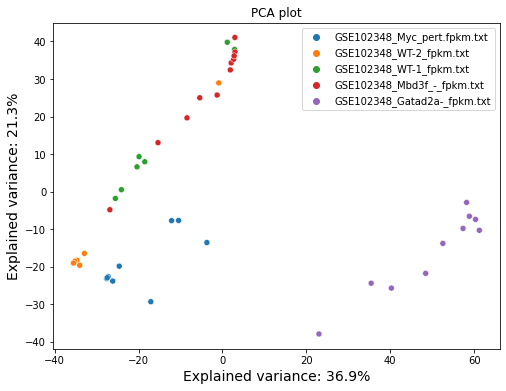

In [150]:
plt.figure(figsize=(8,6))
#plt.scatter(X_pca[:,0], X_pca[:,1], c=exp_numbers)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=exp_labels)
plt.title('PCA plot')
plt.xlabel('Explained variance: ' + str(round(pca.explained_variance_ratio_[0], 3)*100) + '%', fontsize=14)
plt.ylabel('Explained variance: ' + str(round(pca.explained_variance_ratio_[1], 3)*100) + '%', fontsize=14)
plt.legend()
plt.show()

In [151]:
from utils.CUR_decomposition.CUR import *

In [160]:
Xlog = np.log10(X + 1.0)

In [192]:
cur = CUR(10, 0.01, truncated=False)
C,U,R = cur.run_CUR(np.array(Xlog))
C.shape

(43, 23293)

In [193]:
cur.pi_col

array([2.93209928e-05, 2.98824504e-32, 4.29580448e-05, ...,
       4.47160630e-06, 0.00000000e+00, 1.23447058e-06])

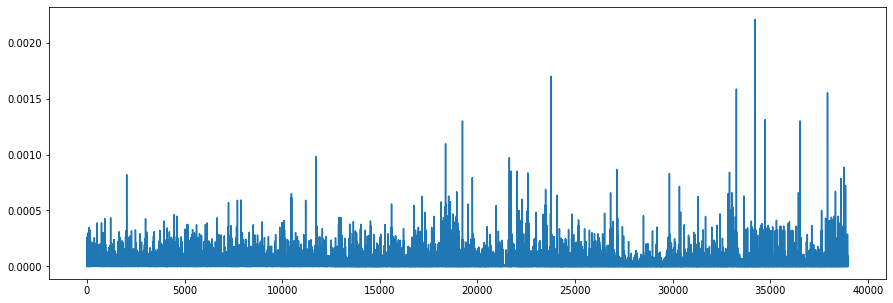

In [194]:
plt.figure(figsize=(15,5))
plt.plot(cur.pi_col)

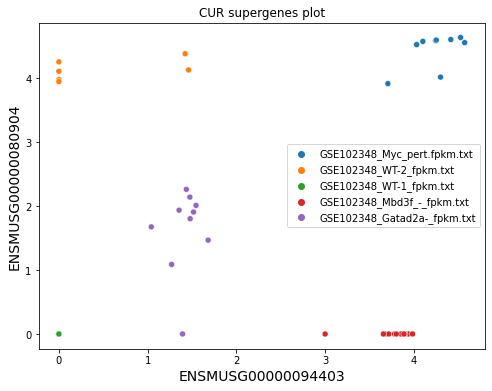

In [199]:
supergenes = np.argsort(cur.pi_col)[::-1][:10]

plt.figure(figsize=(8,6))
#plt.scatter(X_pca[:,0], X_pca[:,1], c=exp_numbers)
g1 = Xlog.iloc[:,supergenes[0]]
g2 = Xlog.iloc[:,supergenes[1]]
sns.scatterplot(x=g1, y=g2, hue=exp_labels)
plt.title('CUR supergenes plot')
plt.xlabel(g1.name, fontsize=14)
plt.ylabel(g2.name, fontsize=14)
plt.legend()
plt.show()

In [201]:
# plt.figure(figsize=(8,6))
# sns.scatterplot(x=C[:,0], y=C[:,1], hue=exp_labels)
# plt.title('PCA plot')
# plt.legend()
# plt.show()

# GSE103221

* What data should be used?

In [258]:
geo_paths = sorted(glob('./Data/GSE103221/*.csv'))

In [259]:
geo_paths

['./Data/GSE103221/GSE103221_normalized_counts.csv',
 './Data/GSE103221/GSE103221_raw_read_counts.csv',
 './Data/GSE103221/GSM3619570_10x_cip_d0.csv',
 './Data/GSE103221/GSM3619571_10x_cip_d3.csv',
 './Data/GSE103221/GSM3619572_10x_cip_d6.csv',
 './Data/GSE103221/GSM3619573_10x_cip_d9.csv',
 './Data/GSE103221/GSM3619574_10x_cip_d12.csv',
 './Data/GSE103221/GSM3619575_10x_cip_d16.csv',
 './Data/GSE103221/GSM3619576_10x_cip_d18.csv',
 './Data/GSE103221/GSM3619577_10x_cip_d22.csv',
 './Data/GSE103221/GSM3619578_10x_cip_d26.csv',
 './Data/GSE103221/GSM3619579_10x_cip_d32.csv',
 './Data/GSE103221/GSM3619580_10x_cip_d36.csv',
 './Data/GSE103221/GSM3619581_10x_cip_d40.csv',
 './Data/GSE103221/GSM3629847_10x_osk_mef.csv',
 './Data/GSE103221/GSM3629848_10x_osk_esc.csv',
 './Data/GSE103221/GSM3629849_10x_osk_d1.csv',
 './Data/GSE103221/GSM3629850_10x_osk_d0.csv',
 './Data/GSE103221/GSM3629851_10x_osk_d3.csv',
 './Data/GSE103221/GSM3629852_10x_osk_d5.csv',
 './Data/GSE103221/GSM3629853_10x_osk_d6

In [260]:
df1 = pd.read_csv(geo_paths[2], index_col=0)

In [249]:
df2 = pd.read_csv(geo_paths[1], index_col=0)

In [292]:
df1.columns

Index(['AAACCTGAGAGTCGGT', 'AAACCTGAGCCAGGAT', 'AAACCTGCATGGAATA',
       'AAACCTGTCAGGCCCA', 'AAACCTGTCCCTAACC', 'AAACCTGTCTCGTATT',
       'AAACCTGTCTCTAGGA', 'AAACGGGAGATGTGGC', 'AAACGGGAGCTTTGGT',
       'AAACGGGAGGGTATCG',
       ...
       'TTTGGTTAGGAGTACC', 'TTTGGTTCAACTGCGC', 'TTTGGTTCATAGGATA',
       'TTTGGTTCATCCTAGA', 'TTTGGTTTCAGTTTGG', 'TTTGTCAGTAGCACGA',
       'TTTGTCAGTATCAGTC', 'TTTGTCAGTCTACCTC', 'TTTGTCAGTCTTGCGG',
       'TTTGTCATCGCAAGCC'],
      dtype='object', length=4054)

## short exploration

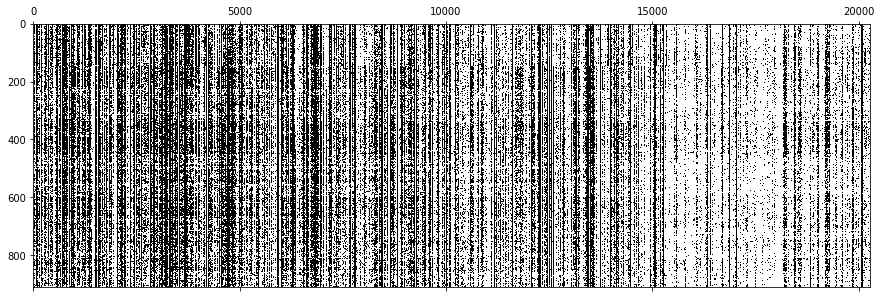

In [291]:
plt.figure(figsize=(15,5))
plt.spy(X, aspect=7)

In [272]:
X = df2.T

In [280]:
labels = [i.split('_')[0] for i in X.index]

In [274]:
pca = PCA(2)
X_pca = pca.fit_transform(np.log10(X + 1.0))

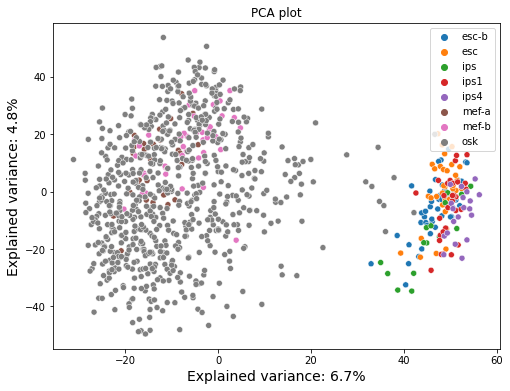

In [281]:
plt.figure(figsize=(8,6))
#plt.scatter(X_pca[:,0], X_pca[:,1], c=exp_numbers)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels)
plt.title('PCA plot')
plt.xlabel('Explained variance: ' + str(round(pca.explained_variance_ratio_[0], 3)*100) + '%', fontsize=14)
plt.ylabel('Explained variance: ' + str(round(pca.explained_variance_ratio_[1], 3)*100) + '%', fontsize=14)
plt.legend()
plt.show()

In [282]:
Xlog = np.log10(X + 1.0)

cur = CUR(15, 0.01, truncated=False)
C,U,R = cur.run_CUR(np.array(Xlog))
C.shape

(912, 17173)

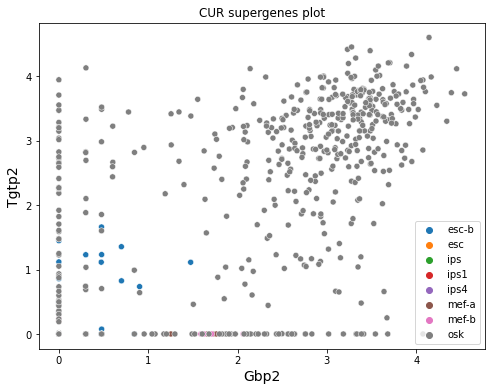

In [285]:
supergenes = np.argsort(cur.pi_col)[::-1][:10]

plt.figure(figsize=(8,6))
#plt.scatter(X_pca[:,0], X_pca[:,1], c=exp_numbers)
g1 = Xlog.iloc[:,supergenes[0]]
g2 = Xlog.iloc[:,supergenes[1]]
sns.scatterplot(x=g1, y=g2, hue=labels)
plt.title('CUR supergenes plot')
plt.xlabel(g1.name, fontsize=14)
plt.ylabel(g2.name, fontsize=14)
plt.legend()
plt.show()

# GSE112004
* what do different letters mean?

In [72]:
gse_paths = glob('./Data/GSE112004/*.tsv')

In [91]:
#preprocessing and merging
symbols = set()
mdf = pd.DataFrame()

for path in tqdm(gse_paths):

    df = pd.read_csv(path, sep='\t', index_col=0)
    symbols = symbols.union(df.index)
    df = df.groupby(level=0).sum()
    df.columns = [col + '__' + os.path.basename(path) for col in df.columns]

    if mdf.shape == (0, 0):
        mdf = df
    else:
        mdf = pd.merge(mdf, df, how='outer', left_index=True, right_index=True)

In [92]:
mdf

,936S_MSCB-001__GSE112004_counts.936S.tsv,936S_MSCB-002__GSE112004_counts.936S.tsv,936S_MSCB-003__GSE112004_counts.936S.tsv,936S_MSCB-004__GSE112004_counts.936S.tsv,936S_MSCB-005__GSE112004_counts.936S.tsv,936S_MSCB-006__GSE112004_counts.936S.tsv,936S_MSCB-007__GSE112004_counts.936S.tsv,936S_MSCB-008__GSE112004_counts.936S.tsv,936S_MSCB-009__GSE112004_counts.936S.tsv,936S_MSCB-010__GSE112004_counts.936S.tsv,...,679T_MSCB-183__GSE112004_counts.679T.tsv,679T_MSCB-184__GSE112004_counts.679T.tsv,679T_MSCB-185__GSE112004_counts.679T.tsv,679T_MSCB-186__GSE112004_counts.679T.tsv,679T_MSCB-187__GSE112004_counts.679T.tsv,679T_MSCB-188__GSE112004_counts.679T.tsv,679T_MSCB-189__GSE112004_counts.679T.tsv,679T_MSCB-190__GSE112004_counts.679T.tsv,679T_MSCB-191__GSE112004_counts.679T.tsv,679T_MSCB-192__GSE112004_counts.679T.tsv
ENSMUSG00000000001.4,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000000028.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
ENSMUSG00000000031.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
ENSMUSG00000000037.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000000049.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000108811.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000108812.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000108813.1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0
ENSMUSG00000108814.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
#saving
#mdf.T.to_csv('./Data/GSE112004/data_all.csv')

## short exploration

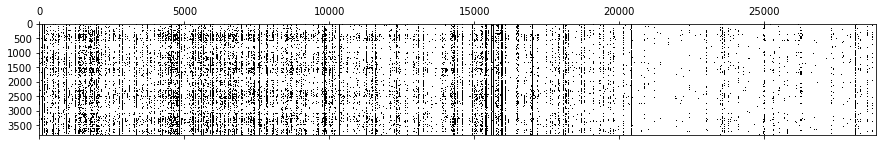

In [100]:
plt.figure(figsize=(15,5))
plt.spy(mdf.T)

In [111]:
X = mdf.T

In [113]:
X = X.fillna(0.0)

In [114]:
pca = PCA(2)
X_pca = pca.fit_transform(np.log10(X + 1.0))

In [132]:
labels = [i.split('_')[0][-1] for i in X.index]

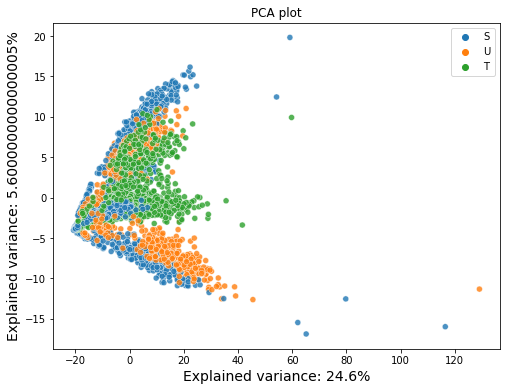

In [133]:
plt.figure(figsize=(8,6))
#plt.scatter(X_pca[:,0], X_pca[:,1], c=exp_numbers)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, alpha=0.8)
plt.title('PCA plot')
plt.xlabel('Explained variance: ' + str(round(pca.explained_variance_ratio_[0], 3)*100) + '%', fontsize=14)
plt.ylabel('Explained variance: ' + str(round(pca.explained_variance_ratio_[1], 3)*100) + '%', fontsize=14)
plt.legend()
plt.show()

# GSE127927


In [4]:
gse = glob("./Data/GSE127927/GSM*")
print(len(gse))
gse

68


['./Data/GSE127927/GSM3656719_MEF-7F-iPSC-2.genes.results.txt',
 './Data/GSE127927/GSM3656718_MEF-7F-iPSC-1.genes.results.txt',
 './Data/GSE127927/GSM3753566_GFP_d0.genes.results.txt',
 './Data/GSE127927/GSM3656693_7F-Nanog-D3.genes.results.txt',
 './Data/GSE127927/GSM3656691_7F-Nanog-D0.genes.results.txt',
 './Data/GSE127927/GSM3656721_MEF-7F-iPSC-4.genes.results.txt',
 './Data/GSE127927/GSM3656679_7F-Jdp2-D5.genes.results.txt',
 './Data/GSE127927/GSM3656720_MEF-7F-iPSC-3.genes.results.txt',
 './Data/GSE127927/GSM3656724_MEF-Y_F-iPSC-2.genes.results.txt',
 './Data/GSE127927/GSM3656682_7F-Kdm2b-D1.genes.results.txt',
 './Data/GSE127927/GSM3656717_MEF-3.genes.results.txt',
 './Data/GSE127927/GSM3656678_7F-Jdp2-D3.genes.results.txt',
 './Data/GSE127927/GSM3656713_GFP-control-D5.genes.results.txt',
 './Data/GSE127927/GSM3656676_7F-Jdp2-D0.genes.results.txt',
 './Data/GSE127927/GSM3656677_7F-Jdp2-D1.genes.results.txt',
 './Data/GSE127927/GSM3656683_7F-Kdm2b-D3.genes.results.txt',
 './Data/

In [15]:
df = pd.read_csv(gse[0], sep='\t', index_col=0)

In [31]:
#preprocessing and merging
# symbols = {}
# mdf = pd.DataFrame()

# for path in tqdm(gse):

#     df = pd.read_csv(path, sep='\t', index_col=0)
#     symbols.update(df.Symbol.to_dict())
#     df = df.groupby(level=0).sum()
#     df.columns = [col + '__' + os.path.basename(path) for col in df.columns]

#     if mdf.shape == (0, 0):
#         mdf = df
#     else:
#         mdf = pd.merge(mdf, df, left_index=True, right_index=True)

# GSE62772

In [17]:
pd.read_csv('data/GSE62772/GSE62772_all_genes_reprogramming.fpkm_tracking.csv')

,gene_id,gene_short_name,locus,hiF-T_P14,2dd_DOX_plus,5dd_DOX_plus,8dd_DOX_plus,10dd_DOX_plus_SSEA3_pos,14dd_DOX_plus_SSEA3_pos,20dd_DOX_plus_TRA_plus,24dd_TRA_pos_DOX_plus,24dd_TRA_pos_DOX_minus,hIPSC-T_P10
0,ENSG00000000003.9,TSPAN6,chrX:99883666-99894988,14.66780,14.35510,18.75820,35.416900,47.672700,50.65490,38.88380,38.405600,34.02820,38.80380
1,ENSG00000000005.5,TNMD,chrX:99839798-99854882,0.00000,0.00000,0.00000,0.202068,0.211075,1.03463,1.93668,0.901606,1.25704,1.61839
2,ENSG00000000419.7,DPM1,chr20:49505584-49575092,30.25940,26.77980,26.75960,24.091500,25.901700,23.96090,32.26400,31.577200,32.90510,28.60270
3,ENSG00000000457.8,SCYL3,chr1:169631244-169863408,4.32631,3.95876,3.70529,3.573150,3.888220,3.73826,3.36952,3.545050,3.62512,3.20174
4,ENSG00000000460.11,C1orf112,chr1:169631244-169863408,4.87518,11.07140,9.90240,7.146970,7.664040,8.10739,9.93671,8.412480,10.31440,12.86540
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53905,ENSGR0000237040.1,DPH3P2,chrY:59208304-59208554,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000
53906,ENSGR0000237531.1,RP11-309M23.1,chrY:900955-905100,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000
53907,ENSGR0000237801.1,AMDP1,chrY:59161253-59162245,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000
53908,ENSGR0000248421.1,RP11-325D5.3,chrY:2087556-2370846,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000


In [18]:
pd.read_csv('data/GSE62772/GSE62772_all_genes_LSD1i.fpkm_tracking.csv')

,gene_id,gene_short_name,locus,5dd_DOX_plus,5dd_DOX_plus_LSD1,14dd_DOX_plus_SSEA3_pos,13dd_DOX_plus_LSD1_SSEA3_pos,20dd_DOX_plus_TRA_plus,13dd_DOX_plus_LSD1_TRA_pos
0,ENSG00000000003.9,TSPAN6,chrX:99883666-99894988,18.72960,16.563100,52.22010,54.186200,40.3031,39.477900
1,ENSG00000000005.5,TNMD,chrX:99839798-99854882,0.00000,0.059754,1.06470,0.465052,2.0089,0.351263
2,ENSG00000000419.7,DPM1,chr20:49505584-49575092,27.09740,21.459200,24.69670,33.162000,33.4336,34.489700
3,ENSG00000000457.8,SCYL3,chr1:169631244-169863408,3.92450,3.696420,3.85343,3.839750,3.4928,3.632060
4,ENSG00000000460.11,C1orf112,chr1:169631244-169863408,9.27843,6.259670,8.35516,10.975700,10.2978,9.699230
...,...,...,...,...,...,...,...,...,...
53905,ENSGR0000237040.1,DPH3P2,chrY:59208304-59208554,0.00000,0.000000,0.00000,0.000000,0.0000,0.000000
53906,ENSGR0000237531.1,RP11-309M23.1,chrY:900955-905100,0.00000,0.000000,0.00000,0.000000,0.0000,0.000000
53907,ENSGR0000237801.1,AMDP1,chrY:59161253-59162245,0.00000,0.000000,0.00000,0.000000,0.0000,0.000000
53908,ENSGR0000248421.1,RP11-325D5.3,chrY:2087556-2370846,0.00000,0.000000,0.00000,0.000000,0.0000,0.000000
